In [ ]:
!pip install -q kaggle
!echo ' {"username":"keshavvel","key":"6dd3d1db00771ee02f8c33b9e0e33c97"} ' > kaggle.json
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!unzip -q chest-xray-pneumonia.zip
!rm -rf chest-xray-pneumonia.zip kaggle.json

100% 2.29G/2.29G [01:47<00:00, 23.6MB/s]
100% 2.29G/2.29G [01:47<00:00, 22.8MB/s]


In [ ]:
!pip install pillow
!pip install cryptography
!pip install Crypto
!pip install pycryptodome

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.3 MB/s eta 0:00:00


In [ ]:
import os

def rrmdir(path):
    for entry in os.scandir(path):
        if entry.is_dir():
            rrmdir(entry)
        else:
            os.remove(entry)
    os.rmdir(path)

rrmdir("/content/chest_xray/__MACOSX")

In [ ]:
from email.mime import image
import os
import zipfile
from PIL import Image
from cryptography.fernet import Fernet
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
from Crypto.Util.Padding import pad, unpad

In [ ]:
# Generating 16 bytes (128 bit) key
key = Fernet.generate_key()

In [ ]:
# Function to compress image files
def compress_image(image_path, output_path, quality):
    """
    Compress an image, retaining its original dimensions for the learning mode
    but reducing file size on disk.
    :param image_path: Path to the original image.
    :param output_path: Path to save the compressed image.
    :param quality: Quality level for compression, between 1 (worst) and 95 (best). 85 is recommended.
    """
    with Image.open(image_path) as img:
        img.save(output_path, 'JPEG', optimize=True, quality=quality)

# Function to zip image files
def zip_files(source_folder, output_zip):
    print("Compressing files")
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(source_folder):
            for file in files:
                if file.endswith('.jpeg'):
                    full_path = os.path.join(root, file)
                    # Compress and save the image temporarily
                    compressed_image_path = full_path + '.compressed.jpeg'
                    compress_image(full_path, compressed_image_path, quality=50)
                    # Add the compressed image to the zip
                    zipf.write(compressed_image_path, os.path.relpath(compressed_image_path, source_folder))
                    # Remove the temporary compressed image
                    os.remove(compressed_image_path)

# Function to encrypt image files
def encrypt_image(input_file, output_file, key):
    cipher = AES.new(key, AES.MODE_CBC)
    with open(input_file, 'rb') as f_in:
        with open(output_file, 'wb') as f_out:
            f_out.write(cipher.iv)
            data = f_in.read()
            f_out.write(cipher.encrypt(pad(data, AES.block_size)))

# Function to decrypt image files
def decrypt_image(input_file, output_file, key):
    with open(input_file, 'rb') as f_in:
        iv = f_in.read(16)  # AES block size is 16 bytes
        cipher = AES.new(key, AES.MODE_CBC, iv)
        with open(output_file, 'wb') as f_out:
            data = f_in.read()
            f_out.write(unpad(cipher.decrypt(data), AES.block_size))

# Function to unzip image files
def unzip_files(input_zip, output_folder):
    with zipfile.ZipFile(input_zip, 'r') as zip_ref:
        zip_ref.extractall(output_folder)

# Encrypt and compress images
def encrypt_files(root_dir):
    for root, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.jpeg'):
                image_path = os.path.join(root, file)
                zip_files(root, image_path + '.zip')  # Compress the entire directory
                encrypt_image(image_path + '.zip', image_path + '.enc', key)
                os.remove(image_path + '.zip')  # Remove the zip file after encryption

# Decrypt and decompress images
def decrypt_files(root_dir):
    for root, _, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.enc'):
                image_path = os.path.join(root, file)
                base_image_path = image_path.rsplit('.enc', 1)[0]
                decrypt_image(image_path, base_image_path + '.zip', key)
                unzip_files(base_image_path + '.zip', root)  # Decompress in the same directory
                os.remove(base_image_path + '.zip')  # Remove the zip file after decompression
                os.remove(image_path)  # Remove the encrypted file

encrypt_files('chest_xray')
decrypt_files('chest_xray')

Compressing files


In [ ]:
from __future__ import print_function, division

from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import random
import os
# CUDA_LAUNCH_BLOCKING=1
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUDNN_HANDLE_ERROR'] = "1"
# torch.backends.cudnn.benchmark = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
device

device(type='cuda', index=0)

In [ ]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
g = torch.Generator()
g.manual_seed(0)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [ ]:
!nvidia-smi

Mon Dec 11 11:16:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:

import os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

if torch.cuda.is_available():
    print('CUDA is available. Working on GPU')
    DEVICE = torch.device('cuda')
else:
    print('CUDA is not available. Working on CPU')
    DEVICE = torch.device('cpu')

CUDA is available. Working on GPU


In [ ]:
!mv -n ./chest_xray/test/NORMAL/* ./chest_xray/val/NORMAL/
!mv -n ./chest_xray/test/PNEUMONIA/* ./chest_xray/val/PNEUMONIA/

# Compression - Encryption

In [ ]:
!pip install PyCryptodome

In [ ]:
key = get_random_bytes(16)

In [ ]:
# Function to compress image files
import zipfile
import os

def compress_dataset(source_folder, output_zip):
    with zipfile.ZipFile(output_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(source_folder):
            for file in files:
                zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), os.path.join(source_folder, '..')))

# Function to encrypt image files
from Crypto.Cipher import AES
from Crypto.Util.Padding import pad
from Crypto.Random import get_random_bytes
import os

def encrypt_file(input_file, output_file, key):
    cipher = AES.new(key, AES.MODE_CBC)
    with open(input_file, 'rb') as f_in:
        with open(output_file, 'wb') as f_out:
            f_out.write(cipher.iv)
            data = f_in.read()
            f_out.write(cipher.encrypt(pad(data, AES.block_size)))


In [ ]:
# Function to decrypt image files
from Crypto.Cipher import AES
from Crypto.Util.Padding import unpad

def decrypt_file(input_file, output_file, key):
    with open(input_file, 'rb') as f_in:
        iv = f_in.read(16)  # AES block size is 16 bytes
        cipher = AES.new(key, AES.MODE_CBC, iv)
        with open(output_file, 'wb') as f_out:
            data = f_in.read()
            f_out.write(unpad(cipher.decrypt(data), AES.block_size))

# Function to decompress image files
def decompress_dataset(input_zip, output_folder):
    with zipfile.ZipFile(input_zip, 'r') as zip_ref:
        zip_ref.extractall(output_folder)


In [ ]:
DIR_MAIN = 'chest_xray/'
DIR_TRAIN = DIR_MAIN + 'train/'
DIR_VAL = DIR_MAIN + 'val/'
DIR_TEST = DIR_MAIN + 'test/'

# Number of labels - 200
labels = os.listdir(DIR_TRAIN)

# Initialize labels encoder
encoder_labels = LabelEncoder()
encoder_labels.fit(labels)

# Create lists of files and labels for training (100,000 items)
files_train = []
labels_train = []
for label in labels:
    for filename in os.listdir(DIR_TRAIN + label):
        files_train.append(DIR_TRAIN + label + '/' + filename)
        labels_train.append(label)



In [ ]:
import os
import shutil

# Define the path to the original folder containing the subfolders
original_folder = DIR_VAL

# Define the path to the new folder where the files will be copied
new_folder = f"{DIR_VAL}/images"

if not os.path.exists(new_folder):
    os.makedirs(new_folder)


normal_folder = f'{DIR_VAL}/NORMAL'
pneumonia_folder = f'{DIR_VAL}/PNEUMONIA'

# Define the path to the val_annotations.txt file
val_file = f'{DIR_VAL}/val_annotations.txt'

# Write the heading to the val_annotations.txt file if it doesn't already exist
if not os.path.exists(val_file):
    with open(val_file, 'w') as f:
        f.write('')

# Loop through the normal folder and copy the files to the new folder
for file in os.listdir(normal_folder):
    if file.endswith('.jpeg'):
        file_path = os.path.join(normal_folder, file)
        new_file_path = os.path.join(new_folder, file)
        shutil.copy(file_path, new_file_path)
        with open(val_file, 'a') as f:
            f.write('{}\t{}\n'.format(file, 'NORMAL'))

# Loop through the pneumonia folder and copy the files to the new folder
for file in os.listdir(pneumonia_folder):
    if file.endswith('.jpeg'):
        file_path = os.path.join(pneumonia_folder, file)
        new_file_path = os.path.join(new_folder, file)
        shutil.copy(file_path, new_file_path)
        with open(val_file, 'a') as f:
            f.write('{}\t{}\n'.format(file, 'PNEUMONIA'))


In [ ]:
shutil.rmtree(normal_folder)
shutil.rmtree(pneumonia_folder)

In [ ]:
import os
import shutil

# Define the path to the original folder containing the subfolders
original_folder = DIR_TEST

# Define the path to the new folder where the files will be copied
new_folder = f"{DIR_TEST}/images"

if not os.path.exists(new_folder):
    os.makedirs(new_folder)


normal_folder = f'{DIR_TEST}/NORMAL'
pneumonia_folder = f'{DIR_TEST}/PNEUMONIA'

# Define the path to the test_annotations.txt file
test_file = f'{DIR_TEST}/test_annotations.txt'

# Write the heading to the test_annotations.txt file if it doesn't already exist
if not os.path.exists(test_file):
    with open(test_file, 'w') as f:
        f.write('')

# Loop through the normal folder and copy the files to the new folder
for file in os.listdir(normal_folder):
    if file.endswith('.jpeg'):
        file_path = os.path.join(normal_folder, file)
        new_file_path = f'{new_folder}/{file}'
        shutil.copy(file_path, new_file_path)
        with open(test_file, 'a') as f:
            f.write('{}\t{}\n'.format(file, 'NORMAL'))

# Loop through the pneumonia folder and copy the files to the new folder
for file in os.listdir(pneumonia_folder):
    if file.endswith('.jpeg'):
        file_path = os.path.join(pneumonia_folder, file)
        new_file_path = f'{new_folder}/{file}'
        shutil.copy(file_path, new_file_path)
        with open(test_file, 'a') as f:
            f.write('{}\t{}\n'.format(file, 'PNEUMONIA'))


In [ ]:
shutil.rmtree(normal_folder)
shutil.rmtree(pneumonia_folder)

# Data processing

In [ ]:
# Create lists of files and labels for validation
files_val = []
labels_val = []


In [ ]:
for filename in os.listdir(f'{DIR_VAL}images'):
    files_val.append(f'{DIR_VAL}images/{filename}')

temp_files_val = files_val

val_df = pd.read_csv(DIR_VAL + 'val_annotations.txt', sep='\t', names=["File", "Label"], usecols=["File", "Label"])
for f in temp_files_val:
    f = f.replace('images/','')
    l = val_df.loc[val_df['File'] == f[len(DIR_VAL):]]['Label'].values[0]
    labels_val.append(l)

# List of files for testing (10'000 items)
files_test = []
for filename in os.listdir(f'{DIR_TEST}/images'):
    files_test.append(f'{DIR_TEST}images/{filename}')
    files_test = sorted(files_test)


# Dataset

In [ ]:
class ImagesDataset(Dataset):
    def __init__(self, files, labels, encoder, transforms, mode):
        super().__init__()
        self.files = files
        self.labels = labels
        self.encoder = encoder
        self.transforms = transforms
        self.mode = mode

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        pic = Image.open(self.files[index]).convert('RGB')

        if self.mode == 'train' or self.mode == 'val':
            x = self.transforms(pic)
            label = self.labels[index]
            y = self.encoder.transform([label])[0]
            return x, y
        elif self.mode == 'test':
            x = self.transforms(pic)
            return x, self.files[index]

transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262]),
    transforms.RandomErasing(p=0.5, scale=(0.06, 0.08), ratio=(1, 3), value=0, inplace=True)
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.4802, 0.4481, 0.3975], [0.2302, 0.2265, 0.2262])
])

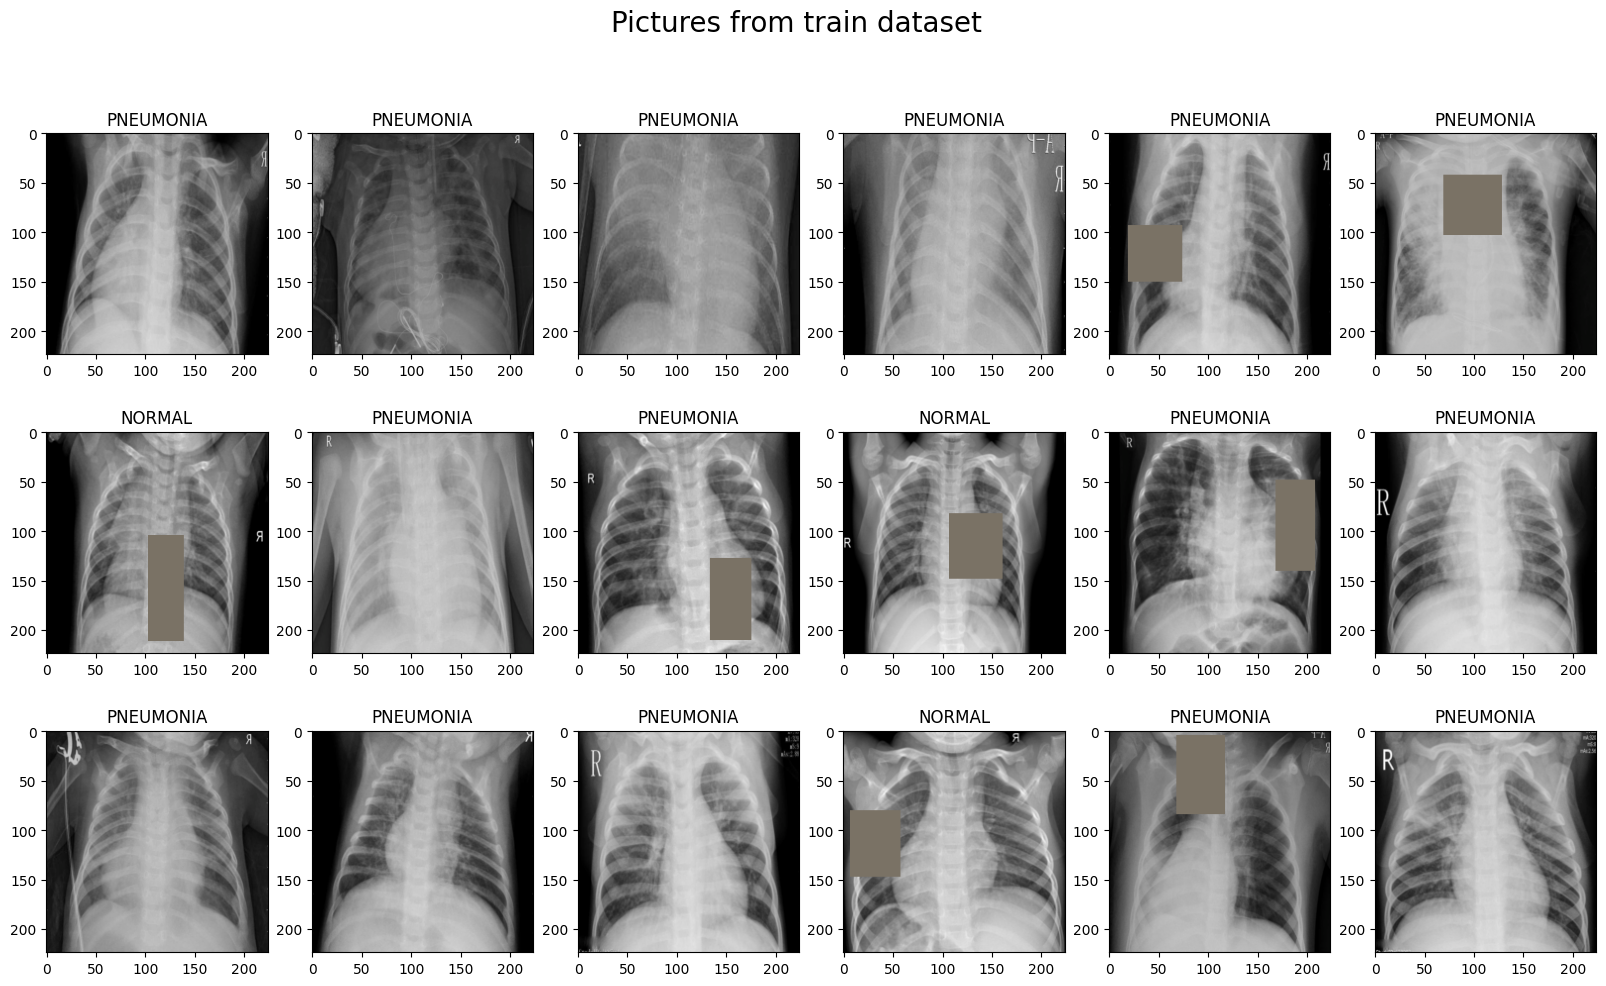

In [ ]:
train_dataset = ImagesDataset(files=files_train,
                              labels=labels_train,
                              encoder=encoder_labels,
                              transforms=transforms_train,
                              mode='train')

val_dataset = ImagesDataset(files=files_val,
                            labels=labels_val,
                            encoder=encoder_labels,
                            transforms=transforms_val,
                            mode='val')

test_dataset = ImagesDataset(files=files_test,
                             labels=None,
                             encoder=None,
                             transforms=transforms_val,
                             mode='test')

fig, axs = plt.subplots(3, 6, figsize=(20,11))
fig.suptitle('Pictures from train dataset', fontsize=20)
for ax in axs.flatten():
    n = np.random.randint(len(train_dataset))
    img = train_dataset[n][0]
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.4802, 0.4481, 0.3975])
    std = np.array([0.2302, 0.2265, 0.2262])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    ax.set_title(encoder_labels.inverse_transform([train_dataset[n][1]])[0])
    ax.imshow(img)

# Functions for training models

In [ ]:
import numpy as np
import torch
import copy
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau

def training(model, model_name, num_epochs, train_dataloader, val_dataloader, patience=5):
    loss_function = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.33, patience=2, verbose=True)

    train_loss_array = []
    train_acc_array = []
    val_loss_array = []
    val_acc_array = []
    lowest_val_loss = np.inf
    best_model = None
    epochs_no_improve = 0

    for epoch in tqdm(range(num_epochs)):
        print('Epoch: {} | Learning rate: {}'.format(epoch + 1, [group['lr'] for group in optimizer.param_groups]))

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            epoch_loss = 0.0
            epoch_correct_items = 0
            epoch_items = 0

            for samples, targets in (train_dataloader if phase == 'train' else val_dataloader):
                samples = samples.to(DEVICE)
                targets = targets.to(DEVICE)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(samples)
                    loss = loss_function(outputs, targets)
                    preds = outputs.argmax(dim=1)
                    correct_items = (preds == targets).float().sum()

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                epoch_loss += loss.item() * samples.size(0)
                epoch_correct_items += correct_items.item()
                epoch_items += len(targets)

            epoch_loss /= epoch_items
            epoch_acc = epoch_correct_items / epoch_items

            if phase == 'train':
                train_loss_array.append(epoch_loss)
                train_acc_array.append(epoch_acc)
            else:
                val_loss_array.append(epoch_loss)
                val_acc_array.append(epoch_acc)
                scheduler.step(epoch_loss)

                if epoch_loss < lowest_val_loss:
                    lowest_val_loss = epoch_loss
                    best_model = copy.deepcopy(model)
                    epochs_no_improve = 0
                    print("\t| New lowest val loss for {}: {}".format(model_name, lowest_val_loss))
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= patience:
                        print('Early stopping!')
                        return best_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array

    return best_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array


In [ ]:
def visualize_training_results(train_loss_array,
                               val_loss_array,
                               train_acc_array,
                               val_acc_array,
                               num_epochs,
                               model_name,
                               batch_size):
    fig, axs = plt.subplots(1, 2, figsize=(14,4))
    fig.suptitle("{} training | Batch size: {}".format(model_name, batch_size), fontsize = 16)
    axs[0].plot(list(range(1, num_epochs+1)), train_loss_array, label="train_loss")
    axs[0].plot(list(range(1, num_epochs+1)), val_loss_array, label="val_loss")
    axs[0].legend(loc='best')
    axs[0].set(xlabel='epochs', ylabel='loss')
    axs[1].plot(list(range(1, num_epochs+1)), train_acc_array, label="train_acc")
    axs[1].plot(list(range(1, num_epochs+1)), val_acc_array, label="val_acc")
    axs[1].legend(loc='best')
    axs[1].set(xlabel='epochs', ylabel='accuracy')
    plt.show();

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Training

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
num_epochs = 15

In [ ]:
num_epochs = 20

### Training DenseNet161

In [ ]:
print(dir(models))

['AlexNet', 'AlexNet_Weights', 'ConvNeXt', 'ConvNeXt_Base_Weights', 'ConvNeXt_Large_Weights', 'ConvNeXt_Small_Weights', 'ConvNeXt_Tiny_Weights', 'DenseNet', 'DenseNet121_Weights', 'DenseNet161_Weights', 'DenseNet169_Weights', 'DenseNet201_Weights', 'EfficientNet', 'EfficientNet_B0_Weights', 'EfficientNet_B1_Weights', 'EfficientNet_B2_Weights', 'EfficientNet_B3_Weights', 'EfficientNet_B4_Weights', 'EfficientNet_B5_Weights', 'EfficientNet_B6_Weights', 'EfficientNet_B7_Weights', 'EfficientNet_V2_L_Weights', 'EfficientNet_V2_M_Weights', 'EfficientNet_V2_S_Weights', 'GoogLeNet', 'GoogLeNetOutputs', 'GoogLeNet_Weights', 'Inception3', 'InceptionOutputs', 'Inception_V3_Weights', 'MNASNet', 'MNASNet0_5_Weights', 'MNASNet0_75_Weights', 'MNASNet1_0_Weights', 'MNASNet1_3_Weights', 'MaxVit', 'MaxVit_T_Weights', 'MobileNetV2', 'MobileNetV3', 'MobileNet_V2_Weights', 'MobileNet_V3_Large_Weights', 'MobileNet_V3_Small_Weights', 'RegNet', 'RegNet_X_16GF_Weights', 'RegNet_X_1_6GF_Weights', 'RegNet_X_32GF_

In [ ]:
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torchvision.models._api import WeightsEnum
from torch.hub import load_state_dict_from_url

def get_state_dict(self, *args, **kwargs):
    kwargs.pop("check_hash")
    return load_state_dict_from_url(self.url, *args, **kwargs)
WeightsEnum.get_state_dict = get_state_dict

efficientnet_b0(weights=EfficientNet_B0_Weights.IMAGENET1K_V1)
efficientnet_b0(weights="DEFAULT")

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
model_densenet161 = models.efficientnet_b0(pretrained=True)
# for param in model_densenet161.parameters():
#     param.requires_grad = False
model_densenet161.classifier = torch.nn.Linear(model_densenet161.classifier[1].in_features, out_features=2)
model_densenet161 = model_densenet161.to(DEVICE)

In [ ]:
# Count the number of trainable parameters
num_trainable_params = sum(p.numel() for p in model_densenet161.parameters() if p.requires_grad)

# Print the number of trainable parameters
print("Number of trainable parameters: {}".format(num_trainable_params))


Number of trainable parameters: 4010110


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]


  5%|▌         | 1/20 [02:16<43:20, 136.87s/it]

	| New lowest val loss for DenseNet161: 1.1995565295219421
Epoch: 2 | Learning rate: [0.0003]


 10%|█         | 2/20 [04:27<40:02, 133.47s/it]

	| New lowest val loss for DenseNet161: 1.1536197245121003
Epoch: 3 | Learning rate: [0.0003]


 15%|█▌        | 3/20 [06:35<37:03, 130.81s/it]

Epoch: 4 | Learning rate: [0.0003]


 20%|██        | 4/20 [08:34<33:36, 126.03s/it]

Epoch: 5 | Learning rate: [0.0003]


 25%|██▌       | 5/20 [10:31<30:40, 122.67s/it]

Epoch 00005: reducing learning rate of group 0 to 9.9000e-05.
Epoch: 6 | Learning rate: [9.9e-05]


 30%|███       | 6/20 [12:29<28:15, 121.11s/it]

Epoch: 7 | Learning rate: [9.9e-05]


 30%|███       | 6/20 [14:26<33:42, 144.45s/it]

Early stopping!


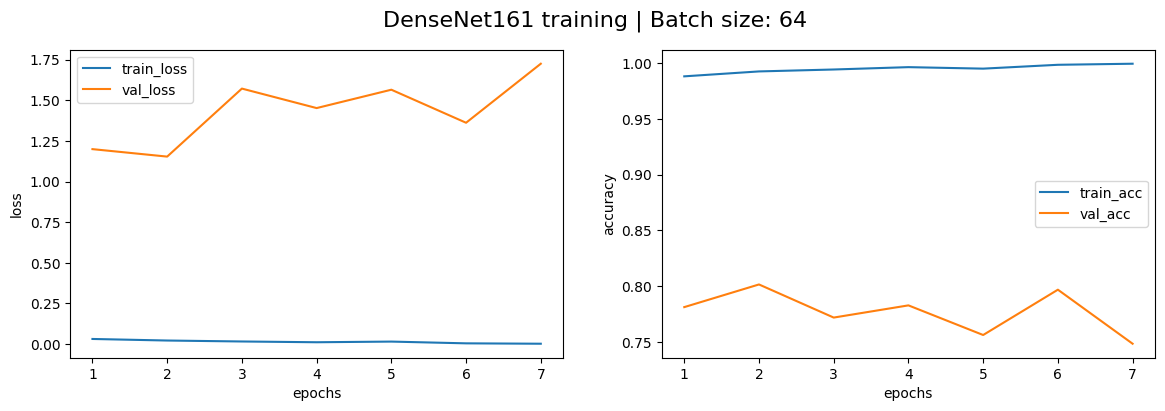


Training results:
	Min val loss 1.1536 was achieved during epoch #2
	Val accuracy during min val loss is 0.8016


In [ ]:
densenet161_training_results = training(model=model_densenet161,
                                        model_name='DenseNet161',
                                        num_epochs=num_epochs,
                                        train_dataloader=train_dataloader,
                                        val_dataloader=val_dataloader)

model_densenet161, train_loss_array, train_acc_array, val_loss_array, val_acc_array = densenet161_training_results

# Post-training analysis
min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

# Visualize results
actual_num_epochs = len(val_loss_array)  # The actual number of epochs completed
visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           actual_num_epochs,  # Use the actual number of epochs here
                           model_name="DenseNet161",
                           batch_size=64)

print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

In [ ]:
model_densenet161, train_loss_array, train_acc_array, val_loss_array_dn, val_acc_array_dn = densenet161_training_results
print(val_acc_array_dn)
print(val_loss_array_dn)

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

### Training ResNet152

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load the pre-trained ResNet-152 model
model_resnet152 = models.resnet152(pretrained=True)

# Freeze the initial convolutional layers
for param in model_resnet152.parameters():
    param.requires_grad = False

# Create additional layers with batch normalization and three dense layers
additional_layers = nn.Sequential(
    nn.Linear(model_resnet152.fc.in_features, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64, 2)
)

# Update the model's architecture
model_resnet152.fc = additional_layers

# Move the model to the specified device
model_resnet152 = model_resnet152.to(DEVICE)


In [ ]:
# Count the number of trainable parameters
num_trainable_params = sum(p.numel() for p in model_resnet152.parameters() if p.requires_grad)

# Print the number of trainable parameters
print("Number of trainable parameters: {}".format(num_trainable_params))


Number of trainable parameters: 566722


In [ ]:
print(f"Training loss array length: {len(train_loss_array)}")
print(f"Validation loss array length: {len(val_loss_array)}")
print(f"Training accuracy array length: {len(train_acc_array)}")
print(f"Validation accuracy array length: {len(val_acc_array)}")

Training loss array length: 6
Validation loss array length: 6
Training accuracy array length: 6
Validation accuracy array length: 6


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]


  5%|▌         | 1/20 [02:12<42:01, 132.71s/it]

	| New lowest val loss for ResNet152: 0.386166550219059
Epoch: 2 | Learning rate: [0.0003]


 10%|█         | 2/20 [04:24<39:44, 132.46s/it]

Epoch: 3 | Learning rate: [0.0003]


 15%|█▌        | 3/20 [06:37<37:31, 132.46s/it]

Epoch: 4 | Learning rate: [0.0003]


 20%|██        | 4/20 [08:51<35:29, 133.11s/it]

Epoch 00004: reducing learning rate of group 0 to 9.9000e-05.
Epoch: 5 | Learning rate: [9.9e-05]


 25%|██▌       | 5/20 [11:03<33:11, 132.75s/it]

Epoch: 6 | Learning rate: [9.9e-05]


 25%|██▌       | 5/20 [13:16<39:50, 159.34s/it]

Early stopping!


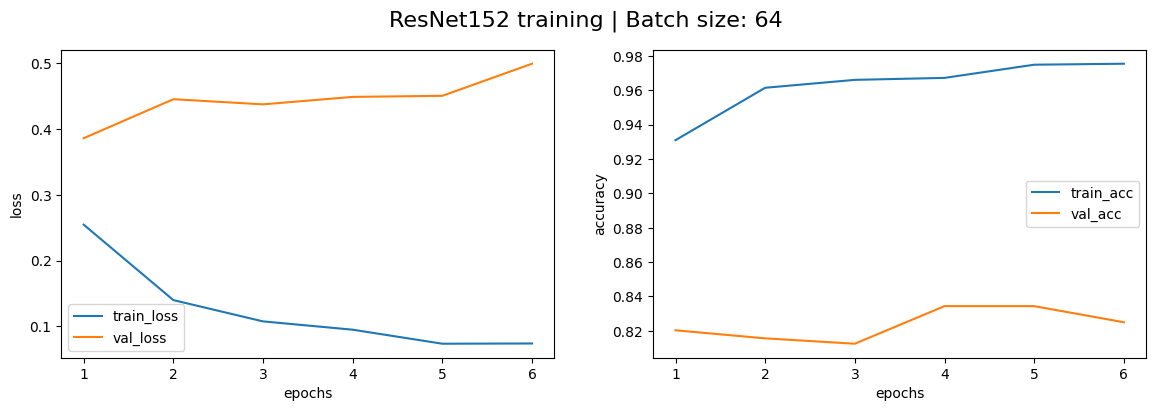


Training results:
	Min val loss 0.3862 was achieved during epoch #1
	Val accuracy during min val loss is 0.8203


In [ ]:
# model_resnet152 = models.resnet152(pretrained=True)
# for param in model_resnet152.parameters():
#     param.requires_grad = False~
# model_resnet152.fc = torch.nn.Linear(model_resnet152.fc.in_features, 2)
# model_resnet152 = model_resnet152.to(DEVICE)

resnet152_training_results = training(model=model_resnet152,
                                      model_name='ResNet152',
                                      num_epochs=num_epochs,
                                      train_dataloader=train_dataloader,
                                      val_dataloader=val_dataloader)

model_resnet152, train_loss_array, train_acc_array, val_loss_array, val_acc_array = resnet152_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

actual_num_epochs = len(val_loss_array)
visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           actual_num_epochs,
                           model_name="ResNet152",
                           batch_size=64)

print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

In [ ]:
model_resnet152, train_loss_array, train_acc_array, val_loss_array_rn, val_acc_array_rn = resnet152_training_results
print(val_acc_array_rn)
print(val_loss_array_rn)

[0.8203125, 0.815625, 0.8125, 0.834375, 0.834375, 0.825]
[0.386166550219059, 0.4454150304198265, 0.4376318544149399, 0.44894697368144987, 0.45059318989515307, 0.4993895202875137]


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

### Training VGG19

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load the pre-trained VGG-19 model with batch normalization
model_vgg19_bn = models.vgg19_bn(pretrained=True)

# Freeze the initial convolutional layers
for param in model_vgg19_bn.parameters():
    param.requires_grad = False


print(model_vgg19_bn)



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [ ]:
# Create additional layers with batch normalization and three dense layers
additional_layers = nn.Sequential(
    nn.Linear(model_vgg19_bn.classifier[6].in_features, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64, 2)
)

# Update the model's architecture
model_vgg19_bn.classifier[6] = additional_layers

# Move the model to the specified device
model_vgg19_bn = model_vgg19_bn.to(DEVICE)


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]


  5%|▌         | 1/20 [02:05<39:52, 125.94s/it]

	| New lowest val loss for VGG19_bn: 0.34967407733201983
Epoch: 2 | Learning rate: [0.0003]


 10%|█         | 2/20 [04:12<37:53, 126.30s/it]

Epoch: 3 | Learning rate: [0.0003]


 15%|█▌        | 3/20 [06:18<35:47, 126.32s/it]

Epoch: 4 | Learning rate: [0.0003]


 20%|██        | 4/20 [08:23<33:30, 125.64s/it]

Epoch 00004: reducing learning rate of group 0 to 9.9000e-05.
Epoch: 5 | Learning rate: [9.9e-05]


 25%|██▌       | 5/20 [10:29<31:25, 125.68s/it]

Epoch: 6 | Learning rate: [9.9e-05]


 25%|██▌       | 5/20 [12:34<37:42, 150.81s/it]

Early stopping!


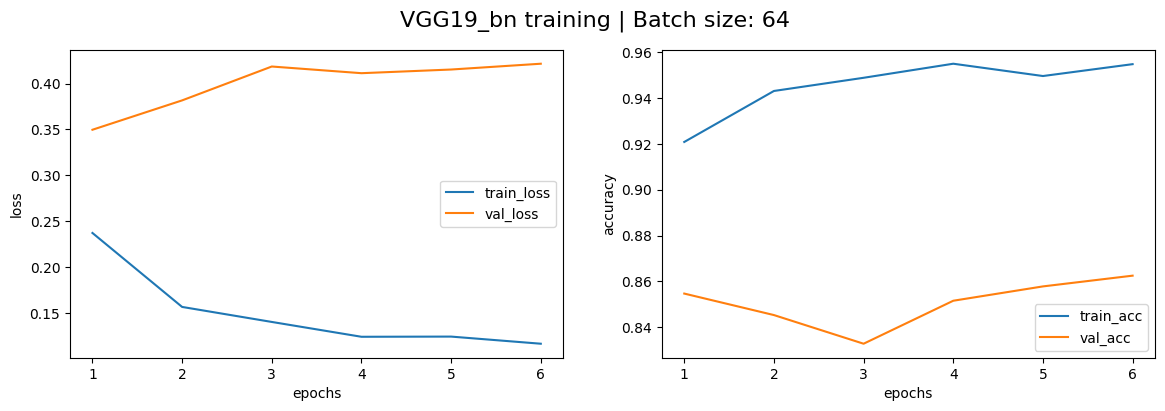


Training results:
	Min val loss 0.3497 was achieved during epoch #1
	Val accuracy during min val loss is 0.8547


In [ ]:
# model_vgg19_bn = models.vgg19_bn(pretrained=True)
# for param in model_vgg19_bn.parameters():
#     param.requires_grad = False
# model_vgg19_bn.classifier[6] = torch.nn.Linear(in_features=model_vgg19_bn.classifier[6].in_features, out_features=2)
# model_vgg19_bn = model_vgg19_bn.to(DEVICE)

vgg19_bn_training_results = training(model=model_vgg19_bn,
                                     model_name='VGG19_bn',
                                     num_epochs=num_epochs,
                                     train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader)

model_vgg19_bn, train_loss_array, train_acc_array, val_loss_array, val_acc_array = vgg19_bn_training_results

min_loss = min(val_loss_array)
min_loss_epoch = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_epoch]

actual_num_epochs = len(val_loss_array)

visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           actual_num_epochs,
                           model_name="VGG19_bn",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during epoch #{}".format(min_loss, min_loss_epoch + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

In [ ]:
model_vgg19_bn, train_loss_array, train_acc_array, val_loss_array_vgg, val_acc_array_vgg = vgg19_bn_training_results
print(val_acc_array_vgg)
print(val_loss_array_vgg)

[0.8546875, 0.8453125, 0.8328125, 0.8515625, 0.8578125, 0.8625]
[0.34967407733201983, 0.3816874027252197, 0.41862146854400634, 0.41134367883205414, 0.4153399169445038, 0.4216647446155548]


### Training ensemble

In [ ]:
# In case we want to use saved weights

# model_vgg19_bn = models.vgg19_bn(pretrained = False)
# model_vgg19_bn.classifier[6] = torch.nn.Linear(in_features=4096, out_features=2)

# model_resnet152 = models.resnet152(pretrained = False)
# model_resnet152.fc = torch.nn.Linear(in_features=2048, out_features=2)

# model_densenet161 = models.densenet161(pretrained = False)
# model_densenet161.classifier = torch.nn.Linear(in_features=2208, out_features=2)

# model_vgg19_bn.load_state_dict(torch.load('VGG19_bn_weights.pth'))
# model_resnet152.load_state_dict(torch.load('ResNet152_weights.pth'))
# model_densenet161.load_state_dict(torch.load('DenseNet161_weights.pth'))

In [ ]:
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights, vgg19_bn, VGG19_BN_Weights, densenet201, DenseNet201_Weights, resnext101_64x4d, ResNeXt101_64X4D_Weights

In [ ]:
resnett_model = resnet50(weights=ResNet50_Weights.DEFAULT, progress=True)
vgg19_model = vgg19_bn(weights=VGG19_BN_Weights.DEFAULT, progress=True)
densenet_model = densenet201(weights=DenseNet201_Weights.DEFAULT, progress=True)
resnext_model = resnext101_64x4d(weights= ResNeXt101_64X4D_Weights.DEFAULT, progress=True)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 176MB/s]
Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/hub/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:03<00:00, 25.4MB/s]
Downloading: "https://download.pytorch.org/models/resnext101_64x4d-173b62eb.pth" to /root/.cache/torch/hub/checkpoints/resnext101_64x4d-173b62eb.pth
100%|██████████| 319M/319M [00:04<00:00, 69.8MB/s]


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
class EnsembleModel(nn.Module):
    def __init__(self, modelA, modelB, modelC):
        super().__init__()
        self.modelA = modelA
        self.modelB = modelB
        self.modelC = modelC
        self.classifier = nn.Linear(2 * 3, 2)

    def forward(self, x):
        x1 = self.modelA(x)
        x2 = self.modelB(x)
        x3 = self.modelC(x)
        x = torch.cat((x1, x2, x3), dim=1)
        out = self.classifier(x)
        return out

ensemble_model = EnsembleModel(model_densenet161, model_resnet152, model_vgg19_bn)

for param in ensemble_model.parameters():
    param.requires_grad = False

for param in ensemble_model.classifier.parameters():
    param.requires_grad = True

ensemble_model = ensemble_model.to(DEVICE)

In [ ]:
ensemble_training_results = training(model=ensemble_model,
                                     model_name='Ensemble',
                                     num_epochs=num_epochs,
                                     train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader)

ensemble_model, train_loss_array, train_acc_array, val_loss_array, val_acc_array = ensemble_training_results

min_loss = min(val_loss_array)
min_loss_iteration = val_loss_array.index(min_loss)
min_loss_accuracy = val_acc_array[min_loss_iteration]



  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | Learning rate: [0.0003]


  5%|▌         | 1/20 [03:00<57:02, 180.13s/it]

	| New lowest val loss for Ensemble: 2.3014234781265257
Epoch: 2 | Learning rate: [0.0003]


 10%|█         | 2/20 [06:00<54:04, 180.28s/it]

	| New lowest val loss for Ensemble: 1.8072739005088807
Epoch: 3 | Learning rate: [0.0003]


 15%|█▌        | 3/20 [09:00<51:03, 180.23s/it]

	| New lowest val loss for Ensemble: 1.3718724489212035
Epoch: 4 | Learning rate: [0.0003]


 20%|██        | 4/20 [11:58<47:45, 179.12s/it]

	| New lowest val loss for Ensemble: 1.0308562159538268
Epoch: 5 | Learning rate: [0.0003]


 25%|██▌       | 5/20 [14:58<44:52, 179.47s/it]

	| New lowest val loss for Ensemble: 0.805180448293686
Epoch: 6 | Learning rate: [0.0003]


 30%|███       | 6/20 [17:59<42:00, 180.01s/it]

	| New lowest val loss for Ensemble: 0.6455985486507416
Epoch: 7 | Learning rate: [0.0003]


 35%|███▌      | 7/20 [21:00<39:03, 180.28s/it]

	| New lowest val loss for Ensemble: 0.5670465677976608
Epoch: 8 | Learning rate: [0.0003]


 40%|████      | 8/20 [24:00<36:03, 180.26s/it]

	| New lowest val loss for Ensemble: 0.5045490652322769
Epoch: 9 | Learning rate: [0.0003]


 45%|████▌     | 9/20 [27:03<33:13, 181.24s/it]

	| New lowest val loss for Ensemble: 0.47090632617473605
Epoch: 10 | Learning rate: [0.0003]


 50%|█████     | 10/20 [30:06<30:16, 181.63s/it]

	| New lowest val loss for Ensemble: 0.44190027713775637
Epoch: 11 | Learning rate: [0.0003]


 55%|█████▌    | 11/20 [33:07<27:13, 181.53s/it]

Epoch: 12 | Learning rate: [0.0003]


 60%|██████    | 12/20 [36:10<24:15, 181.92s/it]

	| New lowest val loss for Ensemble: 0.43075149655342104
Epoch: 13 | Learning rate: [0.0003]


 65%|██████▌   | 13/20 [39:11<21:12, 181.81s/it]

Epoch: 14 | Learning rate: [0.0003]


 70%|███████   | 14/20 [42:11<18:07, 181.27s/it]

Epoch: 15 | Learning rate: [0.0003]


 75%|███████▌  | 15/20 [45:12<15:06, 181.22s/it]

	| New lowest val loss for Ensemble: 0.42824895679950714
Epoch: 16 | Learning rate: [0.0003]


 80%|████████  | 16/20 [48:13<12:03, 180.93s/it]

	| New lowest val loss for Ensemble: 0.4210547924041748
Epoch: 17 | Learning rate: [0.0003]


 85%|████████▌ | 17/20 [51:14<09:02, 180.93s/it]

	| New lowest val loss for Ensemble: 0.41491802632808683
Epoch: 18 | Learning rate: [0.0003]


 90%|█████████ | 18/20 [54:15<06:02, 181.18s/it]

	| New lowest val loss for Ensemble: 0.4143578827381134
Epoch: 19 | Learning rate: [0.0003]


 95%|█████████▌| 19/20 [57:17<03:01, 181.28s/it]

Epoch: 20 | Learning rate: [0.0003]


100%|██████████| 20/20 [1:00:17<00:00, 180.88s/it]


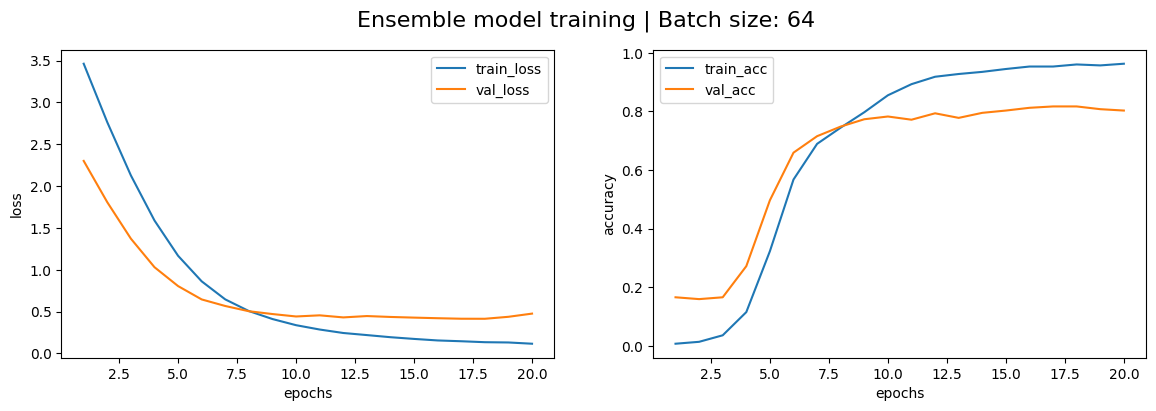


Training results:
	Min val loss 0.4144 was achieved during iteration #18
	Val accuracy during min val loss is 0.8172


In [ ]:
actual_num_epochs = len(val_loss_array)
visualize_training_results(train_loss_array,
                           val_loss_array,
                           train_acc_array,
                           val_acc_array,
                           actual_num_epochs,
                           model_name="Ensemble model",
                           batch_size=64)
print("\nTraining results:")
print("\tMin val loss {:.4f} was achieved during iteration #{}".format(min_loss, min_loss_iteration + 1))
print("\tVal accuracy during min val loss is {:.4f}".format(min_loss_accuracy))

In [ ]:
ensemble_model, train_loss_array, train_acc_array, val_loss_array_ensemble, val_acc_array_ensemble = ensemble_training_results
print(val_acc_array_ensemble)
print(val_loss_array_ensemble)

[0.165625, 0.159375, 0.165625, 0.271875, 0.496875, 0.659375, 0.715625, 0.7484375, 0.7734375, 0.7828125, 0.771875, 0.79375, 0.778125, 0.7953125, 0.803125, 0.8125, 0.8171875, 0.8171875, 0.8078125, 0.803125]
[2.3014234781265257, 1.8072739005088807, 1.3718724489212035, 1.0308562159538268, 0.805180448293686, 0.6455985486507416, 0.5670465677976608, 0.5045490652322769, 0.47090632617473605, 0.44190027713775637, 0.45553269386291506, 0.43075149655342104, 0.44690029621124266, 0.43617728650569915, 0.42824895679950714, 0.4210547924041748, 0.41491802632808683, 0.4143578827381134, 0.43803287446498873, 0.47610735297203066]


# Classifying test dataset and saving results to csv-file

In [ ]:
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

all_preds = []
all_files = []

ensemble_model.eval()
with torch.no_grad():
    for samples, f_names in tqdm(test_dataloader):
        samples = samples.to(DEVICE)
        outputs = ensemble_model(samples)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.tolist())
        all_files.extend(f_names)

all_filenames = [f_name[30:] for f_name in all_files]
all_preds_decoded = encoder_labels.inverse_transform(all_preds)

submission_ensemble_df = pd.DataFrame(list(zip(all_filenames, all_preds_decoded)), columns =['File', 'Prediction'])
submission_ensemble_df.to_csv('test_predictions_ensemble.csv', header=False, index=False)
submission_ensemble_df.head(10)

0it [00:00, ?it/s]


,File,Prediction


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

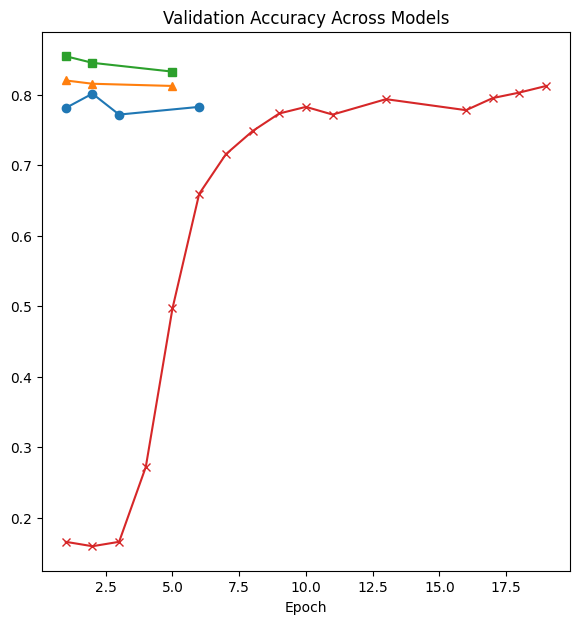

In [ ]:
# Plots
# Data for DenseNet 161 with specified epochs
epochs_densenet = [1, 2, 3, 6]  # Adjusted according to the provided epochs
val_accuracy_densenet = [0.78125, 0.8015625, 0.771875, 0.7828125, 0.75625, 0.796875, 0.7484375]
val_loss_densenet = [1.1995565295219421, 1.1536197245121003, 1.5720662295818328, 1.452158784866333, 1.5651751399040221, 1.3618840634822846, 1.725063306093216]

# Data for ResNet 152 with specified epochs
epochs_resnet = [1, 2, 5]  # Adjusted according to the provided epochs
val_accuracy_resnet = [0.8203125, 0.815625, 0.8125, 0.834375, 0.834375, 0.825]
val_loss_resnet = [0.386166550219059, 0.4454150304198265, 0.4376318544149399, 0.44894697368144987, 0.45059318989515307, 0.4993895202875137]

# Data for VGG 19 with specified epochs
epochs_vgg = [1, 2, 5]  # Adjusted according to the provided epochs
val_accuracy_vgg = [0.8546875, 0.8453125, 0.8328125, 0.8515625, 0.8578125, 0.8625]
val_loss_vgg = [0.34967407733201983, 0.3816874027252197, 0.41862146854400634, 0.41134367883205414, 0.4153399169445038, 0.4216647446155548]

# Data for Ensemble Learning with specified epochs
epochs_ensemble = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 16, 17, 18, 19]  # Adjusted according to the provided epochs
val_accuracy_ensemble = [0.165625, 0.159375, 0.165625, 0.271875, 0.496875, 0.659375, 0.715625, 0.7484375, 0.7734375, 0.7828125, 0.771875, 0.79375, 0.778125, 0.7953125, 0.803125, 0.8125, 0.8171875, 0.8171875, 0.8078125, 0.803125]
val_loss_ensemble = [2.3014234781265257, 1.8072739005088807, 1.3718724489212035, 1.0308562159538268, 0.805180448293686, 0.6455985486507416, 0.5670465677976608, 0.5045490652322769, 0.47090632617473605, 0.44190027713775637, 0.45553269386291506, 0.43075149655342104, 0.44690029621124266, 0.43617728650569915, 0.42824895679950714, 0.4210547924041748, 0.41491802632808683, 0.4143578827381134, 0.43803287446498873, 0.47610735297203066]

# Plotting
plt.figure(figsize=(15, 7))

# Plotting Validation Accuracies
plt.subplot(1, 2, 1)
plt.plot(epochs_densenet, val_accuracy_densenet[:len(epochs_densenet)], label='DenseNet 161', marker='o')
plt.plot(epochs_resnet, val_accuracy_resnet[:len(epochs_resnet)], label='ResNet 152', marker='^')
plt.plot(epochs_vgg, val_accuracy_vgg[:len(epochs_vgg)], label='VGG 19', marker='s')
plt.plot(epochs_ensemble, val_accuracy_ensemble[:len(epochs_ensemble)], label='Ensemble Learning', marker='x')
plt.title('Validation Accuracy Across Models')
plt.xlabel('Epoch')
plt


In [ ]:
# Continue plotting for Validation Losses

# Plotting Validation Losses
plt.subplot(1, 2, 2)
plt.plot(epochs_densenet, val_loss_densenet[:len(epochs_densenet)], label='DenseNet 161', marker='o')
plt.plot(epochs_resnet, val_loss_resnet[:len(epochs_resnet)], label='ResNet 152', marker='^')
plt.plot(epochs_vgg, val_loss_vgg[:len(epochs_vgg)], label='VGG 19', marker='s')
plt.plot(epochs_ensemble, val_loss_ensemble[:len(epochs_ensemble)], label='Ensemble Learning', marker='x')
plt.title('Validation Loss Across Models')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Calculating the highest accuracy and the lowest loss for each model
max_accuracy_densenet = max(val_accuracy_densenet)
min_loss_densenet = min(val_loss_densenet)

max_accuracy_resnet = max(val_accuracy_resnet)
min_loss_resnet = min(val_loss_resnet)

max_accuracy_vgg = max(val_accuracy_vgg)
min_loss_vgg = min(val_loss_vgg)

max_accuracy_ensemble = max(val_accuracy_ensemble)
min_loss_ensemble = min(val_loss_ensemble)

# Preparing data for bar graph
models = ['DenseNet 161', 'ResNet 152', 'VGG 19', 'Ensemble Learning']
highest_accuracies = [max_accuracy_densenet, max_accuracy_resnet, max_accuracy_vgg, max_accuracy_ensemble]
lowest_losses = [min_loss_densenet, min_loss_resnet, min_loss_vgg, min_loss_ensemble]

# Plotting bar graph
plt.figure(figsize=(12, 6))

# Bar graph for highest accuracies
plt.subplot(1, 2, 1)
plt.bar(models, highest_accuracies, color='b')
plt.title('Highest Validation Accuracy per Model')
plt.ylabel('Accuracy')

# Bar graph for lowest losses
plt.subplot(1, 2, 2)
plt.bar(models, lowest_losses, color='g')
plt.title('Lowest Validation Loss per Model')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()


In [ ]:
!cp test_predictions_ensemble.csv /content/ensemble/